## Applied bioinformatics

#### Input:
       
       1) reads_forward.fasta and reads_reversed.fasta       
       2) reference.fasta

Aim:  Given a set of paired-end reads (1.fastq.gz and 2.fastq.gz) and a reference genome (genome.fasta) from close strain.

    a) Assemble and annotate a plasmid sequence that is absent in the reference genome.
    b) Detect species and strain of your genome.
    

Lets start from the bottom..

### II. Detect species and strain of your genome.

First of all we can assemble scaffold from given reads using Spades, annotate scaffold and reference genome and use this information in order to identify species. For example good identification markers can be 16S rRNA genes or some other conserved genes. Lets try to do it:

Install Spades from oficial site. Make sure that you download latest version of browser:

``` wget http://cab.spbu.ru/files/release3.11.1/SPAdes-3.11.1-Linux.tar.gz``` # Download

``` tar -xzf SPAdes-3.11.1-Linux.tar.gz ``` # unzip

After that you have to move to master directory of the tool and check if it works:

``` ./spades.py -h```

If everything is alright, start assemble! It can take some time. Check if your computer can habdle that. In this example, you may need >= 5 GB RAM. If you do not specify ```-m``` argument, the default value is 250 Gb. So we do not..

``` ./spades.py --phred-offset 33 --pe1-1 1.fastq.gz --pe1-2 2.fastq.gz -o /home/nk/Desktop/ ```


After Spades finishes, you will get ```scaffolds.fasta```. Now we can begin annotate scaffolds and reference genome.

First of all, lets install ```prokka```. Tool for prokaryotic gene annotation. 

``` conda install -c conda-forge -c bioconda prokka ```

``` sudo apt-get install libdatetime-perl libxml-simple-perl libdigest-md5-perl git default-jre bioperl ```

In most of cases you may need install some addition Perl packages (Bioperl etc).

First of all type ```prokka --listdb``` and it will show you what databases it has installed to use. So then lets annotate!

```prokka contigs.fasta --outdir /home/nk/Desktop/prolla_output_1``` #  our new contigs anootation

```prokka reference.fasta --outdir /home/nk/Desktop/prolla_output_2``` #  reference genome annotation

After that we have several useful files. First of all is .gff - you can use it in IGV for visualisation. Second is .tsv table - here we can look for some genes sutable for identification. Lets do this.. For search of contamination, extracting 16S sequences and genomes statistics we will use browser tool ContEst16S.

https://www.ezbiocloud.net/tools/contest16s

In contigs we found only one fragment of "Putative pre-16S rRNA nuclease", opposite to reference genome. In reference we have 12 fragments. Moreover fragment one in contigs is identical with fragment one in reference. It is strange... 
Also this tool sow us close relationship between our data and $Bacillus$ $cereus$. 


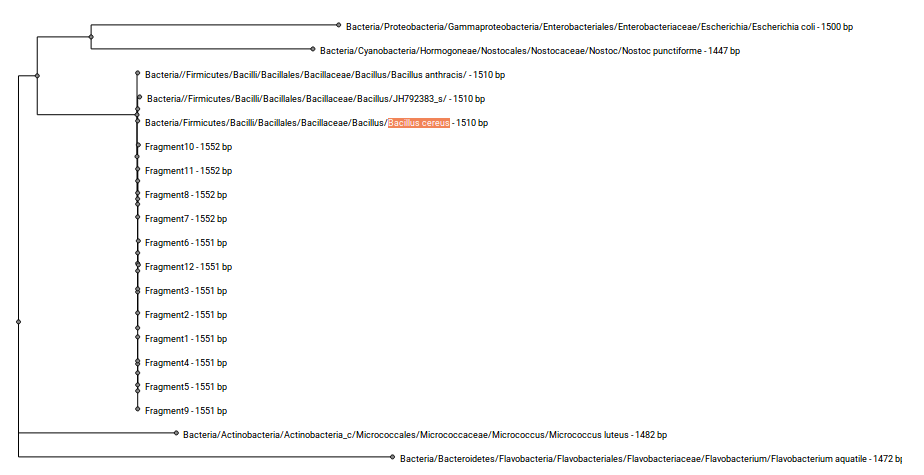

In [3]:
from IPython.core.display import Image, display
display(Image(filename='/home/nk/Desktop/jupyter_notebook/bioinformatics_projects/phylo.png'))

Ok, lets look at GC content, in some cases we can distinguish strains using GC-content. 

* GC content (contigs) = 35.37 %;
* GC content (reference) = 35.58%;

It is also strange. They are approximately identical. Sad. 
So then skip it and lets try extract some more information from our sequences...

### I. Assemble and annotate a plasmid sequence that is absent in the reference genome.

We have already assembled unknown strain's contigs from reads, annotated them and reference genome. 
Our next steps will be the following:
* alighn illumina pair-end reads to reference
* extract all unmapped reads
* alighn them to contigs in order to search long regions with high coverage
* if we find such regions, assemble those reads and search in blasn for similarities (on this step we also identify the strain with some probability).
* and finally annotate this

#### 1) alighn illumina pair-end reads to reference

The way, which was used on seminars:

#### First way (use bowtie2 algorithm) 

* index the reference file

```bowtie2-build reference.fasta some_index```  #       "some_index" is just a word which will be added to all bt2 files


* align

```bowtie2 -x some_index -1 forward.fasta -2 reversed.fasta > alignment.sam```

On this step we can do the following:

```samtools view -S -f4 sample.sam > sample.unmapped.sam``` 

These commands will look in the bam/sam file (in this example we use .sam) and extract reads depending on what is in column 4 in every line. Unmapped reads have “0” and mapped reads will have some other bigger number. -f4 will check for this “0” while -F4 will do the inverse. So -f4 - will give us unmapped reads, opposite to -F4 which give us only mapped reads. For more details: [https://github.com/alvaralmstedt/Tutorials/wiki/Separating-mapped-and-unmapped-reads-from-libraries]

When you have separated your sam files, you will want to make lists of the read names. To make these lists from the sam files:

``` cut -f1 non_mappers1.sam | sort | uniq > non_mappers1_ids.lst ``` # give list of unmapped reads

These lists will be used to pull out the correct reads from the original libraries so that you have your mapped and unmapped data separated and in fastq format. To do this, we will use a script called seqtk. link for tool: https://github.com/lh3/seqtk . 

``` seqtk subseq library1.forward.fastq non_mappers1_ids.lst > forward_non_mappers.fastq ```

``` seqtk subseq library1.reverse.fastq non_mappers1_ids.lst > reverse_non_mappers.fastq ```

After that we aligh them, BUT now to contigs.fasta (use the same pipeline as with reference genome). If you were lucky, by this momment you have alignment.sam file which you get from alignment this pair of unmapped fasta to contigs.fasta. 

* sam -> bam 

```samtools view -S -b alignment.sam > alignment.bam```

* sorting

```samtools sort alignment.bam -o alignment_sorted.bam```

* indexing

``` samtools index alignment_sorted.bam ```

* Launch IGV. Use contigs.fasta as Genome, .gff and indexed .bam file us Files.

#### Second way (use PacBio recommendations) - I prefer this one!

* align Illumina reads

``` bwa index reference.fasta ```

* align Illumina reads and sorting bam file

```bwa mem -t 8 reference.fasta forward.fastq reversed.fastq | samtools sort > aln.bam```

* Index the alignment file

```samtools index aln.bam```

* Extract the fastq files from the bam alignment - those reads that were unmapped to the reference alignment.

```samtools fastq -f 4 -1 unmapped.R1.fastq -2 unmapped.R2.fastq -s unmapped.RS.fastq aln.bam```

-f 4 : only output unmapped reads

-1 : put R1 reads into a file called unmapped.R1.fastq

-2 : put R2 reads into a file called unmapped.R2.fastq

-s : put singleton reads into a file called unmapped.RS.fastq

aln.bam : input alignment file

* alighn unmapped.R1.fastq and unmapped.R2.fastq to contigs.fasta and launch IGV (all instruction was given above).

#### IGV

Assume you have already loaded contigs.fasta, contigs.gff and aln.bam to IGV. So then lets search for potencial plasmids. The logic is the following (Ho): if reads were not mapped to reference genome during algnment, potencially they belong to DNA fragment that is absent in reference, but present in contigs. And when we align them back to contigs we sweep aside some garbish and align only reads that are unique for contigs.  

In my case contings at number 14, 21, 23, 25, 34 and some other NODES with lower length were highly covered. Opposite to lots of totally uncovered contigs. How we can interprete this results? Think about it...

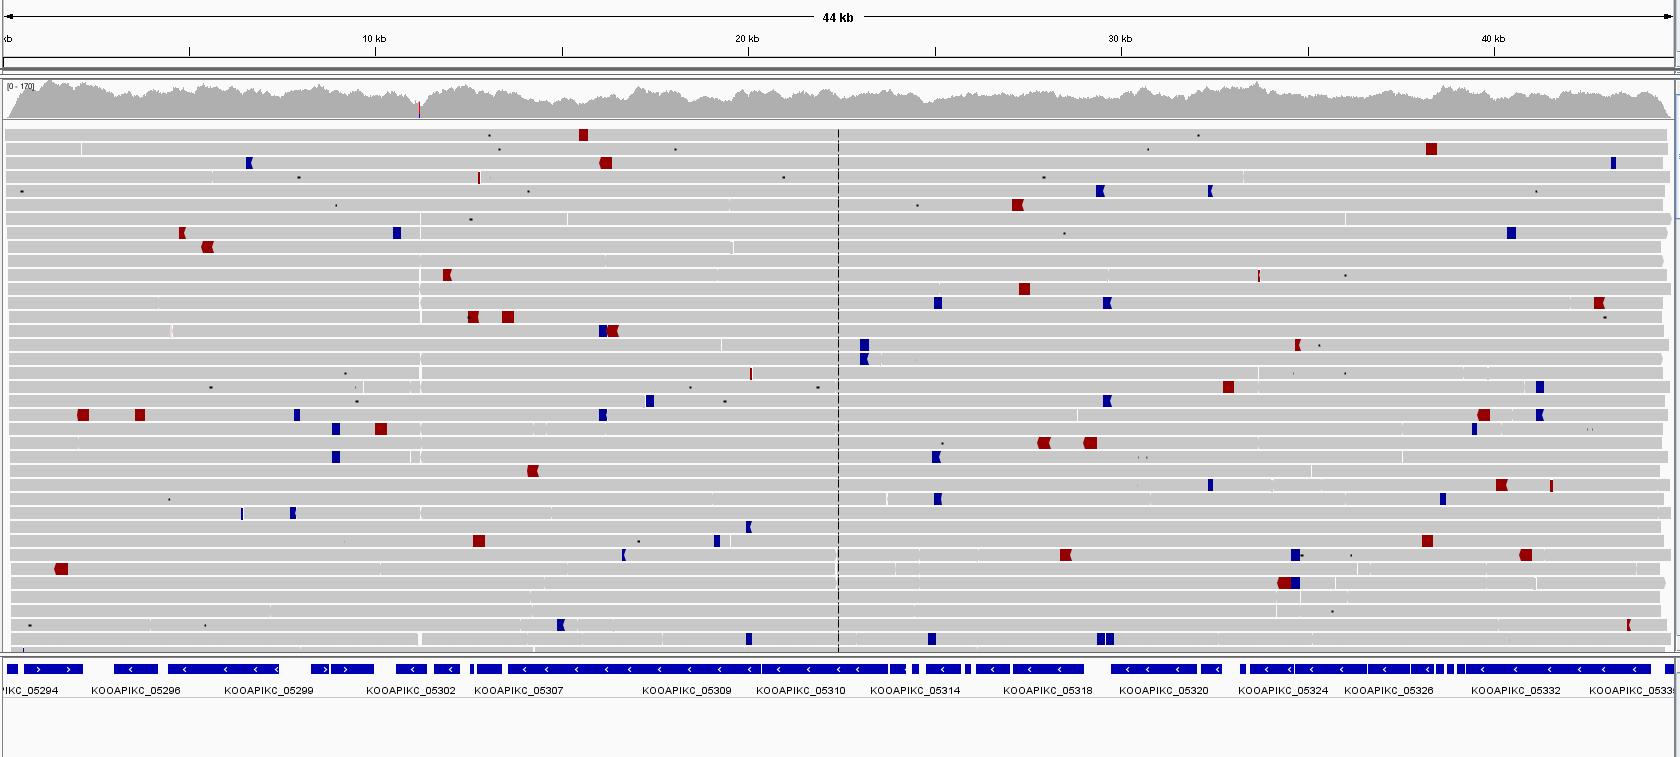

In [1]:
from IPython.core.display import Image, display
display(Image(filename='/home/nk/Desktop/jupyter_notebook/example.png'))

So... assume it is our plasmid. Lets assemble it then (We can extraxt fasta from bam, but also we can use raw inmapped fastq. Let ise fastq):

```./spades.py --phred-offset 33 --pe1-1 unmapped.R1.fastq --pe1-2 2.unmapped.R2.fastq -o /home/nk/Desktop/```

Finally we have sequence of that region (assembled_unmapped_reads.fasta). Now we have to ensure that it is our plasmid - smells like blast.
Take the biggest contig from contigs.fasta ang use blastn in order to identify our fragment. It is 96204 bp.

https://blast.ncbi.nlm.nih.gov/Blast.cgi

Hopefully we have only one contender:

$ Bacillus $ $ cereus $ ATCC 10987 plasmid pBc10987

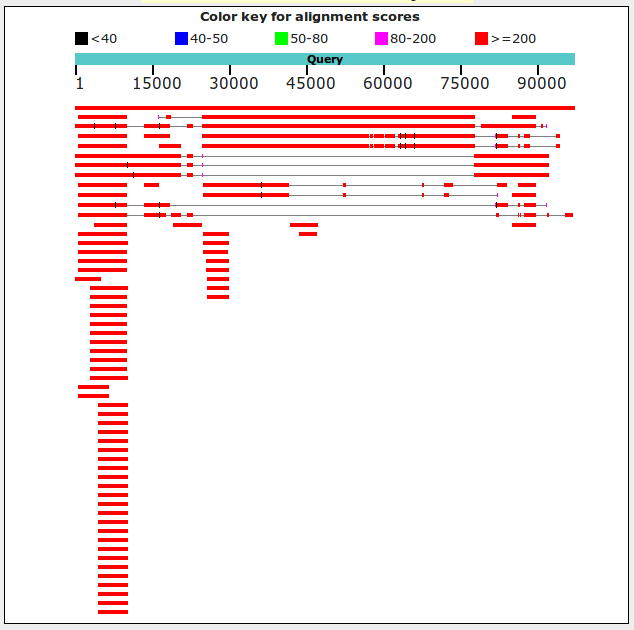

In [6]:
from IPython.core.display import Image, display
display(Image(filename='/home/nk/Desktop/jupyter_notebook/example_blast.png'))

First complete red line is our contender - plasmid pBc10987.

But lets chech who is Bacillus cereus ATCC 10987. 

https://biocyc.org/organism-summary?object=BCER222523
    
Wow! What do we see? There are several "wows". First is that that strain trully has this plasmid, but second that complete genome of this strain is completely identical with our reference genome, even by the amount of bp = 5,224,283 bp. Try Ctrl + F if you do not believe me. How we can interprete this? Think about this..

* note that it explains our failure with 16S identification.

The think is that we assemble all reads and it is not total plasmid. We have to trim garbage, circulirese it and finally annotate.

* All nodes that are < 596kb - disregard as they are unlikely to be plasmids. (So we take first 25 NODES)
...

and so on (read link)

http://sepsis-omics.github.io/tutorials/modules/cmdline_assembly/
...

But I have no time. take first several NODES (amount of bp have to be <= 208369 bp) and with high probability it will be your plasmid. Annotate it..

Finally annotate that with prokka:
    
```prokka assembled_unmapped_reads.fasta --outdir /home/nk/Desktop/output_final_annotation```

Done!